In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import get_from_config
import fur.path_assistant as path_assistant
shift = path_assistant.PathAssistant('shift_03_16_2020')
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")
sum_channel_to_photoelectrons = get_from_config('sum_channel_to_photoelectrons')
N_to_I = 1/sum_channel_to_photoelectrons/cur_to_sum_channel
meas_ROUND = pd.read_csv(shift.get_results_dir().fi('meas_ROUND_03_16_2020.csv'), index_col=0)
meas_ROUND = meas_ROUND.sort_values(by='N',ignore_index=True)

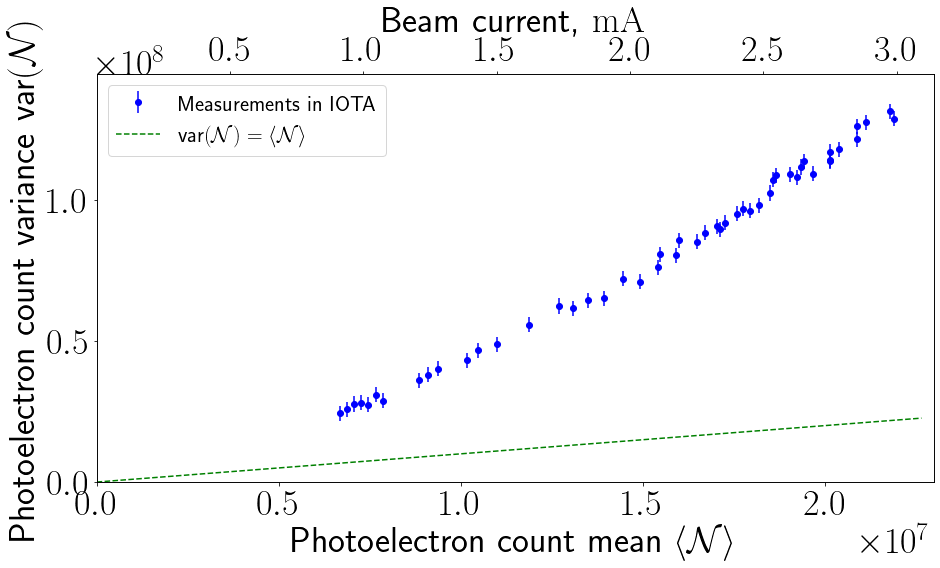

In [2]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 36,'legend.fontsize':22})
colors = {"FLAT": 'blue'}

fig, ax = plt.subplots(figsize=(15, 7.5))
ax.errorbar(meas_ROUND['N'],meas_ROUND['varN'],marker='o',linestyle='None',
            yerr=meas_ROUND['errorbar'],color='b',
            label = r'Measurements in IOTA')
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
handles, labels = ax.get_legend_handles_labels()
order = [1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax.set_xlim(0, 1.05*meas_ROUND['N'].max())
ax.set_ylim(0, 1.1*meas_ROUND['varN'].max())
ax1 = ax.twiny()
ax1.set_xlabel('Beam current, \SI{}{mA}')
ax1.set_xlim(N_to_I*np.asarray(ax.get_xlim()))
ax1.set_xticks(ticks=ax1.get_xticks()[1:-1])
plt.show()

In [3]:
df = pd.read_csv("M_on_grid_precalc.csv", index_col=0)
df_EB = pd.read_csv("M_on_grid_precalc_EB.csv", index_col=0)
df_ET = pd.read_csv("M_on_grid_precalc_ET.csv", index_col=0)

In [4]:
df.head()

,0.06,0.06857142857142857,0.07714285714285714,0.08571428571428573,0.09428571428571428,0.10285714285714287,0.11142857142857143,0.12
6.693879e+06,2.221984e+06,2.478707e+06,2.738453e+06,3.001321e+06,3.267457e+06,3.536921e+06,3.809616e+06,4.085455e+06
6.868607e+06,2.232259e+06,2.489990e+06,2.750771e+06,3.014674e+06,3.281838e+06,3.552339e+06,3.826136e+06,4.103022e+06
7.057312e+06,2.243369e+06,2.502187e+06,2.764074e+06,3.029091e+06,3.297380e+06,3.569039e+06,3.843973e+06,4.122039e+06
7.249983e+06,2.254729e+06,2.514671e+06,2.777677e+06,3.043832e+06,3.313292e+06,3.586113e+06,3.862211e+06,4.141467e+06
7.445827e+06,2.266292e+06,2.527336e+06,2.791512e+06,3.058828e+06,3.329460e+06,3.603451e+06,3.880718e+06,4.161206e+06


In [5]:
es = df.columns.values.astype(np.float64)

In [6]:
es

array([0.06      , 0.06857143, 0.07714286, 0.08571429, 0.09428571,
       0.10285714, 0.11142857, 0.12      ])

In [7]:
def reconstruct_e(avN, varN, en='0'):
    Mexp = avN**2/(varN-avN)
    df0 = {'0':df, 'B':df_EB, 'T':df_ET}[en]
    return np.interp(Mexp,df0.loc[avN,:],es)

In [8]:
reconstruct_e(meas_ROUND['N'][0], meas_ROUND['varN'][0]+0.01e8)

0.06625254563615697

In [9]:
reconstruct_e(meas_ROUND['N'][0], meas_ROUND['varN'][0])

0.07079722174946498

In [10]:
meas_ROUND['e_rec'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']]), axis=1)
meas_ROUND['e_rec_EB'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']], en='B'), axis=1)
meas_ROUND['e_rec_ET'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']], en='T'), axis=1)
meas_ROUND['varNtop'] = meas_ROUND['varN']+meas_ROUND['errorbar']
meas_ROUND['varNbottom'] = meas_ROUND['varN']-meas_ROUND['errorbar']
meas_ROUND['e_error_top'] = meas_ROUND.apply(
    lambda row: reconstruct_e(
        *row[['N', 'varNbottom']]), axis=1)\
        - meas_ROUND['e_rec']
meas_ROUND['e_error_bottom'] = -meas_ROUND.apply(
    lambda row: reconstruct_e(
        *row[['N', 'varNtop']]), axis=1)\
        + meas_ROUND['e_rec']

# Systematic error of reconstructed e due to beam energy uncertainty

In [11]:
# 1e3*meas_ROUND.loc[:,['e_rec_EB', 'e_rec_ET']].apply(lambda col:col-meas_ROUND.loc[:,'e_rec'],axis=0)

In [12]:
meas_ROUND['I_mA'] = meas_ROUND['N']*N_to_I

In [13]:
# calculation of reconstructed sy
import lattice.lattice as lattice
#from lattice.summary_in_undulator import CalcTransverseBeamParams
lattice_df = \
    lattice.read_lattice_file(shift.get_6dsim_dir()\
    .fi("IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"))
from scipy.interpolate import interp1d
bp_df = pd.read_csv(shift.get_results_dir().fi("beam_params_vs_current_round.csv"))
ex_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
# def get_sy(row):
#     Sx, Sy, dx, dy, sxp, syp = CalcTransverseBeamParams(
#         lattice_df, ex_func(row['N']), row['ey_rec'], dpp_func(row['N']))
#     return np.sqrt(Sy**2+syp**2*dy**2)
# meas_FLAT["sy_rec"] = meas_FLAT.apply(get_sy, axis=1)

In [14]:
# # save new meas_FLAT with ey and I_mA
# meas_FLAT.to_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'))

In [15]:
round_df = pd.read_csv(shift.get_results_dir().fi("full_beam_params_vs_current_round.csv"))

In [16]:
meas_FLAT = pd.read_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'), index_col=0)

In [17]:
flat_df = pd.read_csv(shift.get_results_dir().fi("full_beam_params_vs_current_flat.csv"),
                     index_col=0)

In [18]:
from scipy.interpolate import interp1d
bp_df = pd.read_csv(
    shift.get_results_dir().fi("beam_params_vs_current_round.csv"))
ex_r_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
ey_r_func = interp1d(bp_df["N"], bp_df['ey_um'],
                   bounds_error=False, fill_value="extrapolate")


bp_df = pd.read_csv(
    shift.get_results_dir().fi("beam_params_vs_current_flat.csv"))
sx_f_func = interp1d(bp_df["N"], bp_df['Sigma_um_X'],
                   bounds_error=False, fill_value="extrapolate")
sy_f_func = interp1d(bp_df["N"], bp_df['Sigma_um_Y'],
                   bounds_error=False, fill_value="extrapolate")
sz_f_func = interp1d(bp_df["N"], bp_df['sz_um'],
                   bounds_error=False, fill_value="extrapolate")
ex_f_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
ey_f_func = interp1d(bp_df["N"], bp_df['ey_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_f_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
Vrf_f_func = interp1d(bp_df["N"], bp_df['N:IRFEPA'],
                    bounds_error=False, fill_value="extrapolate")

In [19]:
def remove_outliers_omce(df, c1, l1):
    di = df[c1].diff().abs()
    return df[di < l1]
    
def remove_outliers(df, c1, l1, niter):
    for _ in range(niter):
        df = remove_outliers_omce(df, c1, l1)
    return df
round_df = remove_outliers(round_df,'N:IWCMI_recalibrated_to_IWCMI_absolute', 0.1, 10)
round_df = remove_outliers(round_df,'ex_um', 0.01, 10)
round_df = remove_outliers(round_df,'ey_um', 0.01, 10)

flat_df = remove_outliers(flat_df,'N:IWCMI_recalibrated_to_IWCMI_absolute', 0.1, 10)


In [20]:
idx = 10
sp = flat_df['dp/p'][idx]
ex = flat_df['ex_um'][idx]
sz = flat_df['N:IWCMBR'][idx]
Ibeam = -flat_df['N:IWCMI_recalibrated_to_IWCMI_absolute'][idx]
V0=360

In [21]:
from touschek.touschek import get_LamTska
np.sqrt(10e-3)/get_LamTska(lattice_df, V0, sp, ex, sz, Ibeam,
                           aperture_factor=1.0)

1091.546628371648

In [22]:
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
lt_df = pd.read_csv(shift.get_results_dir().fi("life_time_flat_03_16_2020.csv"),
            index_col=0)

In [23]:
idx_ac = 793
a_ac_cm = 0.38
beta_ac_cm = lattice_df.loc[idx_ac, 'Beta_cm_X']
dispersion_ac_cm = lattice_df.loc[idx_ac, 'Dispersion_cm_X']
ex_ac_um = 1e4*a_ac_cm**2/beta_ac_cm
ex_ac_um

22.08329470231749

In [25]:
ap_df = shift.get_Aperture_X_df()

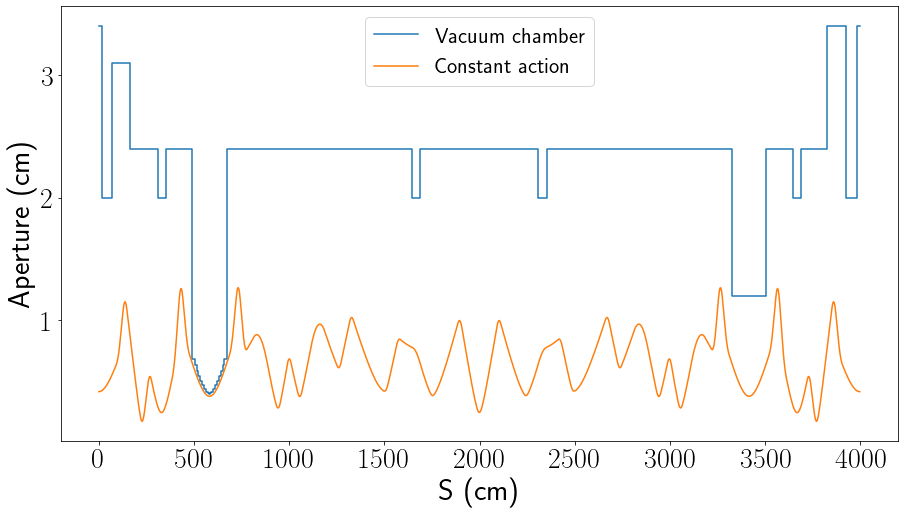

In [40]:
ldf = lattice_df
ap_vs_S = (1e-4*lattice.get_sigma_um(ldf['Beta_cm_X'],   
                ex_ac_um, ldf['Dispersion_cm_X'], 0))
fig, ax = plt.subplots()
ax.plot(ap_df['S_cm'], ap_df['Aperture_cm_X'], label='Vacuum chamber')
ax.plot(ldf['S_cm'], ap_vs_S, label='Constant action')
ax.set_ylabel("Aperture (cm)")
ax.set_xlabel("S (cm)")
ax.legend()
plt.show()

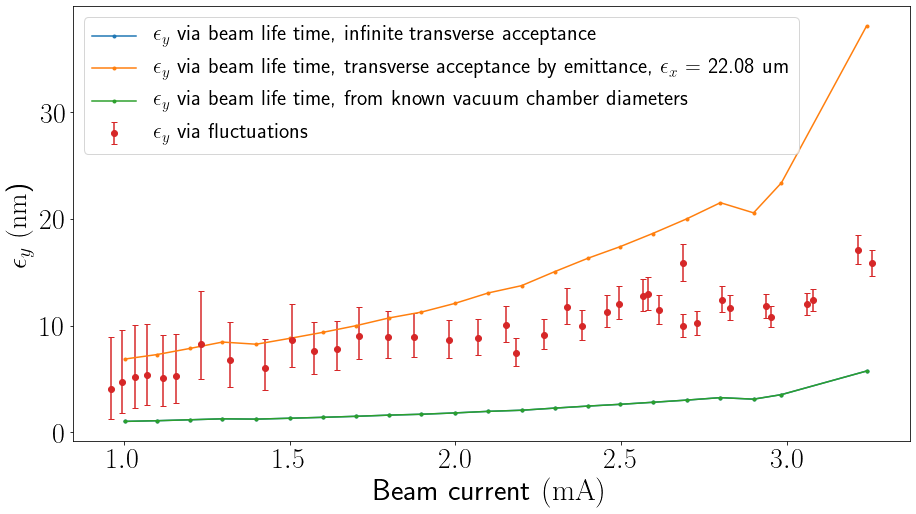

In [29]:

lt_df['N'] = i_to_photoel*lt_df['I (mA)']

def get_ey_from_lifetime_func(
    momentum_aperture,
    fixed_emittance,
    variable_aperture):
    def get_ey_from_lifetime(row):
        Ibeam = row['I (mA)']
        lt = row['Beam life time (Sec)']
        avN = row['N']
        V0 = Vrf_f_func(avN)
        sp = dpp_func(avN)
        ex = ex_f_func(avN)
        sz = 1e-4*sz_f_func(avN)
        lamTska = get_LamTska(lattice_df, V0, sp, ex, sz, Ibeam,
          aperture_factor=momentum_aperture,
          use_transverse_acceptance_octupole=True,
          use_constant_transverse_acceptance=False,
          constant_acceptance_cm=1.0,
          use_transverse_acceptance_by_emittance=fixed_emittance,
          emittance_acceptance_um=ex_ac_um,
          use_variable_aperture_df=variable_aperture,
          variable_aperture_df=ap_df
         )
        return 1e3*(lt*lamTska)**2
    return get_ey_from_lifetime
lt_df['ey_rec_no_transv_acc'] = lt_df.apply(get_ey_from_lifetime_func(
    1.0, False, False), axis=1)
lt_df['ey_rec_transv_acc_by_ex'] = lt_df.apply(get_ey_from_lifetime_func(
    1.0, True, False), axis=1)
lt_df['ey_rec_variable_acc_df'] = lt_df.apply(get_ey_from_lifetime_func(
    1.0, False, True), axis=1)
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=\
       r'\usepackage{siunitx}'
      +r'\newcommand{\e}{\epsilon}')
plt.rcParams.update({'figure.figsize':(15,8),
                     'font.size': 28,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
fs = 28
color='tab:red'
fig, ax = plt.subplots()
yerr = 1e3*np.array([meas_FLAT['ey_error_bottom'],meas_FLAT['ey_error_top']])
ax.errorbar(meas_FLAT['N']/i_to_photoel, 1e3*meas_FLAT['ey_rec'],
             marker='o', linestyle='None',
             color=color, yerr=yerr, label=r'$\e_y$ via fluctuations')
ax.plot(lt_df['I (mA)'], lt_df['ey_rec_no_transv_acc'], '.-',
        label=r"$\e_y$ via beam life time, infinite transverse acceptance")
ax.plot(lt_df['I (mA)'], lt_df['ey_rec_transv_acc_by_ex'], '.-',
        label=r"$\e_y$ via beam life time, transverse acceptance by emittance"
       r", $\e_x$ = "+f"{ex_ac_um:.2f} um")
ax.plot(lt_df['I (mA)'], lt_df['ey_rec_variable_acc_df'], '.-',
        label=r"$\e_y$ via beam life time, from known vacuum chamber diameters")
ax.set_ylabel(r"$\e_y$ $(\SI{}{nm}$)", fontsize=fs)
ax.set_xlabel(r"Beam current $(\SI{}{mA})$")
ax.legend()
# plt.title(f"Momentum acceptance multiplier = {ap:.2f}")
plt.show()

In [33]:
idx = 0
gamma = get_from_config("gamma")
Ibeam = flat_df['N:IWCMI_recalibrated_to_IWCMI_absolute'][idx]
sxp = flat_df['Angle_spread_rad_X'][idx]
Ibeam, sxp

(-2.980817368849504, 0.0008869045448651799)

In [34]:
sxp*gamma

0.16731428204508228

In [35]:
aperture_factor=1
row = lt_df.loc[0, :]
Ibeam = row['I (mA)']
lt = row['Beam life time (Sec)']
avN = row['N']
V0 = Vrf_f_func(avN)
sp = dpp_func(avN)
ex = ex_f_func(avN)
sz = 1e-4*sz_f_func(avN)

gamma0 = get_from_config("gamma")
e = get_from_config("e")
c = get_from_config("c_m/s")*100
me = get_from_config("me_MeV")*1e6
alpha = get_from_config("ring_alpha")
q = get_from_config("RF_q")
VSR = get_from_config("VSR")
f0 = 1/get_from_config("IOTA_revolution_period")
fRF = q*f0
lamRF = c/fRF


etas = alpha-1/gamma**2
Ks = (alpha*gamma**2-1)/(gamma**2-1)
phiacc = np.arcsin(VSR/V0)
nus0 = np.sqrt(q*V0*np.abs(Ks)/2/np.pi/me/gamma)
nus = nus0*np.sqrt(np.cos(phiacc))
fs = f0*nus
dP_Psep = aperture_factor*2*nus0/q/np.abs(etas)*np.sqrt(np.cos(phiacc)
                                        - (np.pi/2-phiacc)*np.sin(phiacc))
Gs = lamRF/2/np.pi*q/nus*np.abs(etas)
ldf = lattice_df
ldf['Sigma_um_X'] = lattice.get_sigma_um(ldf['Beta_cm_X'], ex,
                                         ldf['Dispersion_cm_X'], sp)
em = dP_Psep**2*ldf['Beta_cm_X']/gamma**2/ex/1e-4\
        / (1+(sp*ldf['Beta_cm_X']*ldf["Phi_X"]/ldf["Sigma_um_X"]/1e-4)**2)
dP_Psep

0.002820703840378702

In [36]:
np.sqrt(15e-3)/get_LamTska(lattice_df, V0, sp, ex, sz, Ibeam,
                          aperture_factor=ap)

877.0984998543333

In [37]:
from scipy import interpolate
touschek_func_df = pd.read_csv("touschek_func.csv", header=None)
CI = interpolate.interp1d(touschek_func_df.iloc[:, 0],
                          touschek_func_df.iloc[:, 1])

In [41]:
emittance_acceptance_um = 22 # um
np.asarray([
np.abs((1e-4*lattice.get_sigma_um(ldf['Beta_cm_X'], emittance_acceptance_um,
                           ldf['Dispersion_cm_X'], sp))\
/(np.sqrt(ldf['Beta_cm_X']*ldf.loc[i,'H'])+ldf['Dispersion_cm_X'])).min()
for i in ldf.index])

array([0.0022665 , 0.0022665 , 0.0022665 , 0.0022665 , 0.0022665 ,
       0.0022665 , 0.0022665 , 0.0022665 , 0.0022665 , 0.0022665 ,
       0.0022665 , 0.0022665 , 0.0022665 , 0.0022665 , 0.0022665 ,
       0.0022665 , 0.0022665 , 0.0022665 , 0.0022665 , 0.0022665 ,
       0.00226649, 0.00221907, 0.00221536, 0.0022101 , 0.00220301,
       0.00219372, 0.00226649, 0.00226649, 0.00226649, 0.00240793,
       0.00241063, 0.00241262, 0.00241415, 0.00241319, 0.00226649,
       0.00226649, 0.00226649, 0.00226649, 0.00226649, 0.00226649,
       0.00226649, 0.00226649, 0.00226649, 0.00226649, 0.00226649,
       0.00226649, 0.00226649, 0.00226649, 0.00226649, 0.00226649,
       0.00227064, 0.00227133, 0.00227119, 0.00227016, 0.00226804,
       0.0022665 , 0.0022665 , 0.0022665 , 0.00226491, 0.00226517,
       0.00226774, 0.0022732 , 0.0022807 , 0.0022665 , 0.0022665 ,
       0.0022665 , 0.0022665 , 0.0022665 , 0.0022665 , 0.0022665 ,
       0.00226649, 0.00228549, 0.00231956, 0.00235466, 0.00239

In [30]:
3400/4000*1000

850.0

In [31]:
idx_ac = 793
a_ac_cm = 0.38
beta_ac_cm = lattice_df.loc[idx_ac, 'Beta_cm_X']
dispersion_ac_cm = lattice_df.loc[idx_ac, 'Dispersion_cm_X']

In [32]:
daccL = lattice_df['daccL'].values
np.where(daccL < dP_Psep, daccL, dP_Psep) 

array([0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 ,
       0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 ,
       0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 ,
       0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 ,
       0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 ,
       0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 ,
       0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 ,
       0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 ,
       0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 ,
       0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 ,
       0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 ,
       0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 ,
       0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 ,
       0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 ,
       0.0028207 , 0.0028207 , 0.0028207 , 0.0028207 , 0.00282

Remember that a small protion of SLM data at large Ibeam is extrapolated


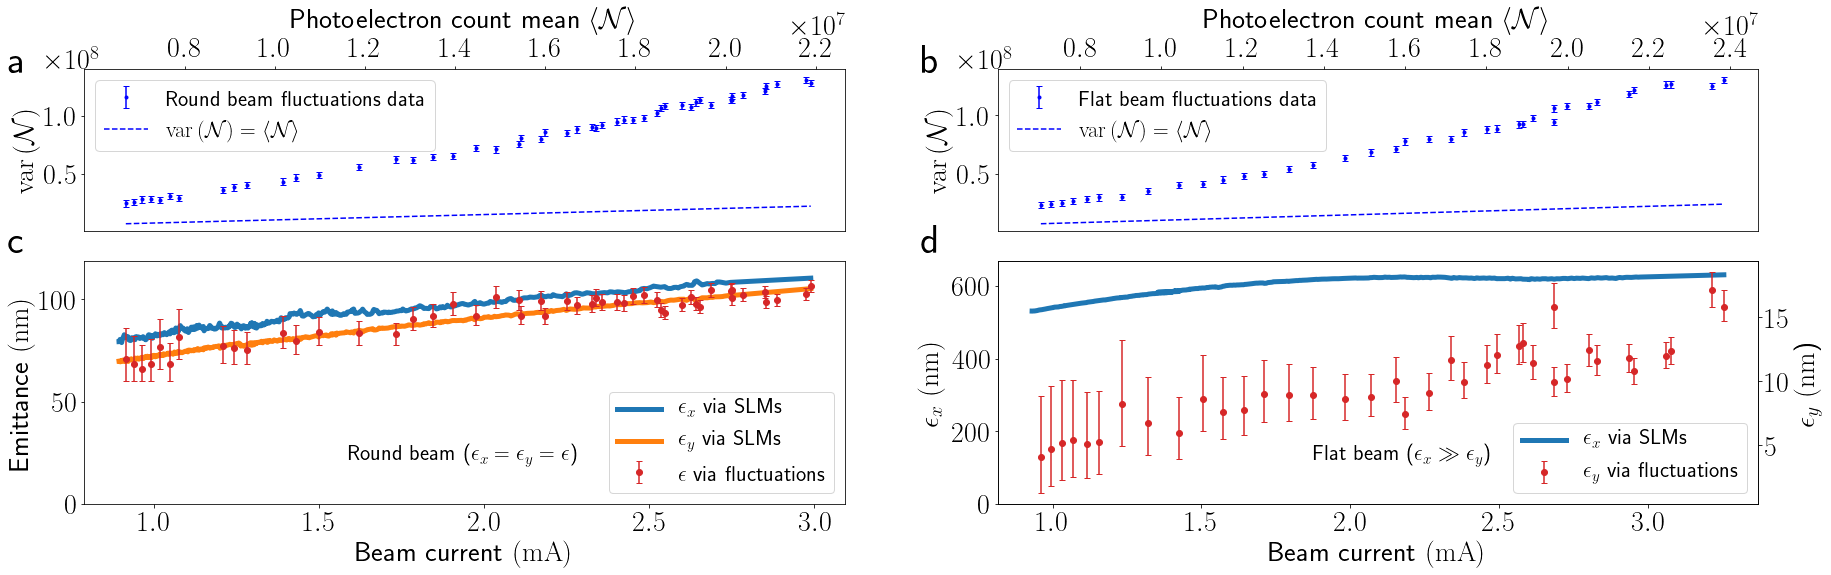

In [19]:
avNlabel = r"Photoelectron count mean $\langle\mathcal{N}\rangle$"
hybrid_balance_error = get_from_config("HybridBalanceError")
fit_errorbar = get_from_config("varN_error_fit")
df = round_df
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=\
       r'\usepackage{siunitx}'
      +r'\newcommand{\e}{\epsilon}')
plt.rcParams.update({'figure.figsize':(30,8),
                     'font.size': 28,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
fs = 28


i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
df = pd.concat([
    pd.DataFrame({'N:IWCMI_recalibrated_to_IWCMI_absolute':[-meas_ROUND['N'].max()/i_to_photoel],
                 'ex_um': ex_r_func(meas_ROUND['N'].max()),
                 'ey_um': ey_r_func(meas_ROUND['N'].max())
                 }),
    df], ignore_index=True)


fig, ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [2, 3]})


photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
axRE = ax[1][0]
axRE.text(0.65, 0.15, r"Round beam ($\e_x=\e_y=\e$)", transform=axRE.transAxes,
      fontsize=22, fontweight='bold', va='bottom', ha='right')
axRE.plot(photoel/i_to_photoel, 1000*df['ex_um'],'-', linewidth=5 ,
        label=r'$\e_x$ via SLMs')
axRE.plot(photoel/i_to_photoel, 1000*df['ey_um'],'-', linewidth=5 ,
        label=r'$\e_y$ via SLMs')

axRE.set_xlabel(r"Beam current $(\SI{}{mA})$", fontsize=fs)
axRE.set_ylabel(r"Emittance $(\SI{}{nm})$", fontsize=fs)

color='tab:red'
yerr = 1e3*np.array([meas_ROUND['e_error_bottom'],meas_ROUND['e_error_top']])
#[meas_FLAT['Sigma_um_Y_Meas_Bottom'], meas_FLAT['Sigma_um_Y_Meas_Top']]
axRE.errorbar(meas_ROUND['N']/i_to_photoel, 1e3*meas_ROUND['e_rec'],
             marker='o', linestyle='None',
             color=color, yerr=yerr, zorder=100,
             label=r"$\e$ via fluctuations")
axRE.set_ylim(0, 1.05*axRE.get_ylim()[1])
axRE.legend(loc='lower right')



axRF = ax[0][0]
pw=1e7
hybrid_errorbar = 2*hybrid_balance_error\
    *np.absolute(meas_ROUND['varN'])
error_bar = np.sqrt(0*hybrid_errorbar**2+fit_errorbar**2)
axRF.errorbar(meas_ROUND['N']/pw, meas_ROUND['varN'],
            marker='.',linestyle='None',yerr=error_bar,color='b',
            label = r'Round beam fluctuations data')
axRF.plot(meas_ROUND['N']/pw, meas_ROUND['N'],color='blue',linestyle='--',
        label = r"$\mathrm{var}\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
axRF.set_ylabel(r"$\mathrm{var}\left(\mathcal{N}\right)$", fontsize=fs)
axRF.set_xlabel(avNlabel, fontsize=fs)
handles, labels = axRF.get_legend_handles_labels()
order = [1,0]
axRF.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
            loc='upper left')
axRF.set_xlim(np.asarray(axRE.get_xlim())*i_to_photoel/pw)
axRF.xaxis.tick_top()
axRF.xaxis.set_label_position('top') 
axRF.set_xticks(ticks=axRF.get_xticks()[2:-1])
axRF.text(0.93, 1.35, r"$\times\SI{e7}{}$", transform=axRF.transAxes,
      fontsize=28, fontweight='bold', va='top', ha='left')
axRF.get_yaxis().get_offset_text().set_x(-0.05)
axRF.xaxis.labelpad = 10




axFE = ax[1][1]
axFE.set_ylabel(r"$\e_x$ $(\SI{}{nm})$", fontsize=fs)

df = flat_df


# extrapolation:
df = pd.concat([
    pd.DataFrame({'N:IWCMI_recalibrated_to_IWCMI_absolute':[-meas_FLAT['N'].max()/i_to_photoel],
                 'ex_um': ex_f_func(meas_FLAT['N'].max())}),
    df], ignore_index=True)
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ln1 = axFE.plot(photoel/i_to_photoel, 1000*df['ex_um'],
                    '-', linewidth=5, label=r'$\e_x$ via SLMs')
axFE.set_ylim(0, 1.05*axFE.get_ylim()[1])
axFE.text(0.65, 0.15, r"Flat beam ($\e_x\gg\e_y$)", transform=axFE.transAxes,
      fontsize=22, fontweight='bold', va='bottom', ha='right')
axFE.set_xlabel(r"Beam current $(\SI{}{mA})$", fontsize=fs)

axFEy = axFE.twinx()
color='tab:red'
yerr = 1e3*np.array([meas_FLAT['ey_error_bottom'],meas_FLAT['ey_error_top']])
ln2 = axFEy.errorbar(meas_FLAT['N']/i_to_photoel, 1e3*meas_FLAT['ey_rec'],
             marker='o', linestyle='None',
             color=color, yerr=yerr, label=r'$\e_y$ via fluctuations')
axFEy.set_ylabel(r"$\e_y$ $(\SI{}{nm}$)", fontsize=fs)

lns = [ln1[0], ln2]
labs = [l.get_label() for l in lns]
axFE.legend(lns, labs, loc='lower right')




axFF = ax[0][1]
pw=1e7
meas_FLAT = \
    pd.read_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'),
                index_col=0)
hybrid_errorbar = 2*hybrid_balance_error\
    *np.absolute(meas_FLAT['varN'])
error_bar = np.sqrt(0*hybrid_errorbar**2+fit_errorbar**2)
axFF.errorbar(meas_FLAT['N']/pw,meas_FLAT['varN'],
            marker='.',linestyle='None',yerr=error_bar,color='b',
            label = r'Flat beam fluctuations data')
axFF.plot(meas_FLAT['N']/pw, meas_FLAT['N'],color='blue',linestyle='--',
        label = r"$\mathrm{var}\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
axFF.set_ylabel(r"$\mathrm{var}\left(\mathcal{N}\right)$", fontsize=fs)
axFF.set_xlabel(avNlabel, fontsize=fs)
handles, labels = axFF.get_legend_handles_labels()
order = [1,0]
axFF.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
            loc='upper left')
axFF.set_xlim(np.asarray(axFE.get_xlim())*i_to_photoel/pw)
axFF.xaxis.tick_top()
axFF.xaxis.set_label_position('top')
axFF.set_xticks(ticks=np.arange(0.8,2.41,0.2))
axFF.text(0.93, 1.35, r"$\times\SI{e7}{}$", transform=axFF.transAxes,
      fontsize=28, fontweight='bold', va='top', ha='left')
axFF.get_yaxis().get_offset_text().set_x(-0.05)
axFF.xaxis.labelpad = 10


fig.subplots_adjust(hspace=0.15)
for i, label in enumerate(('a', 'b', 'c', 'd')):
    x = i // 2
    y = i - 2*x
    axx = ax[x][y] 
    axx.text(-0.1, 1.15, label, transform=axx.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='left')
print("Remember that a small protion of SLM data at large Ibeam is extrapolated")
plt.savefig(path_assistant.get_PRL_images_dir().fi("iota_measurements.png"),
            dpi=300, bbox_inches='tight')
plt.show()

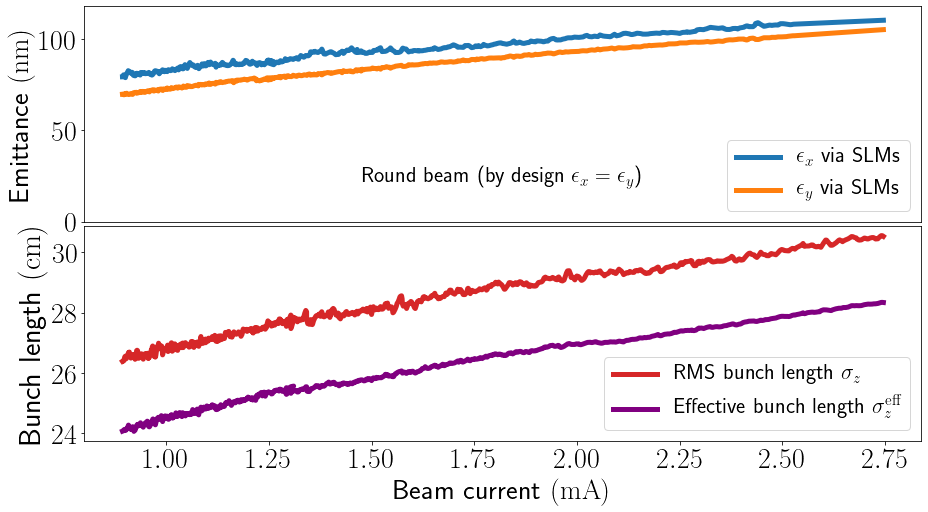

In [23]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axRE, ax2 = axs
df = round_df
df = pd.concat([
    pd.DataFrame({'N:IWCMI_recalibrated_to_IWCMI_absolute':[-meas_ROUND['N'].max()/i_to_photoel],
                 'ex_um': ex_r_func(meas_ROUND['N'].max()),
                 'ey_um': ey_r_func(meas_ROUND['N'].max())
                 }),
    df], ignore_index=True)
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
axRE.text(0.5, 0.15, r"Round beam (by design $\e_x=\e_y$)", transform=axRE.transAxes,
      fontsize=22, fontweight='bold', va='bottom', ha='center')
axRE.plot(photoel/i_to_photoel, 1000*df['ex_um'],'-', linewidth=5 ,
        label=r'$\e_x$ via SLMs')
axRE.plot(photoel/i_to_photoel, 1000*df['ey_um'],'-', linewidth=5 ,
        label=r'$\e_y$ via SLMs')


axRE.set_ylabel(r"Emittance $(\SI{}{nm})$", fontsize=fs)

axRE.set_ylim(0, 1.05*axRE.get_ylim()[1])
axRE.legend(loc='lower right')
axRE.get_xaxis().set_visible(False)

ax2.plot(photoel/i_to_photoel, df['N:IWCMBR'],'-', linewidth=5 ,
        label=r'RMS bunch length $\sigma_z$', color='tab:red')
ax2.plot(photoel/i_to_photoel, df['N:IWCMBE'],'-', linewidth=5 ,
        label=r'Effective bunch length $\sigma_z^{\mathrm{eff}}$',
        color='purple')
ax2.legend(loc='lower right')
ax2.set_ylabel("Bunch length $(\SI{}{cm})$")
ax2.set_yticks(ticks=np.arange(24,31,2))


ax2.set_xlabel(r"Beam current $(\SI{}{mA})$", fontsize=fs)
# ax2.set_ylim(0, 1.05*ax2.get_ylim()[1])
fig.subplots_adjust(hspace=0.02)
plt.savefig(path_assistant.get_PRL_images_dir().fi("ex_ey_round_beam.png"),
            dpi=300, bbox_inches='tight')
plt.show()